# Basic stats

How many ratings? 100,004
How many users? 671
How many movies? 9,125
How many unique ratings? 10
Unique rating values: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Overall ratings mean: 3.54


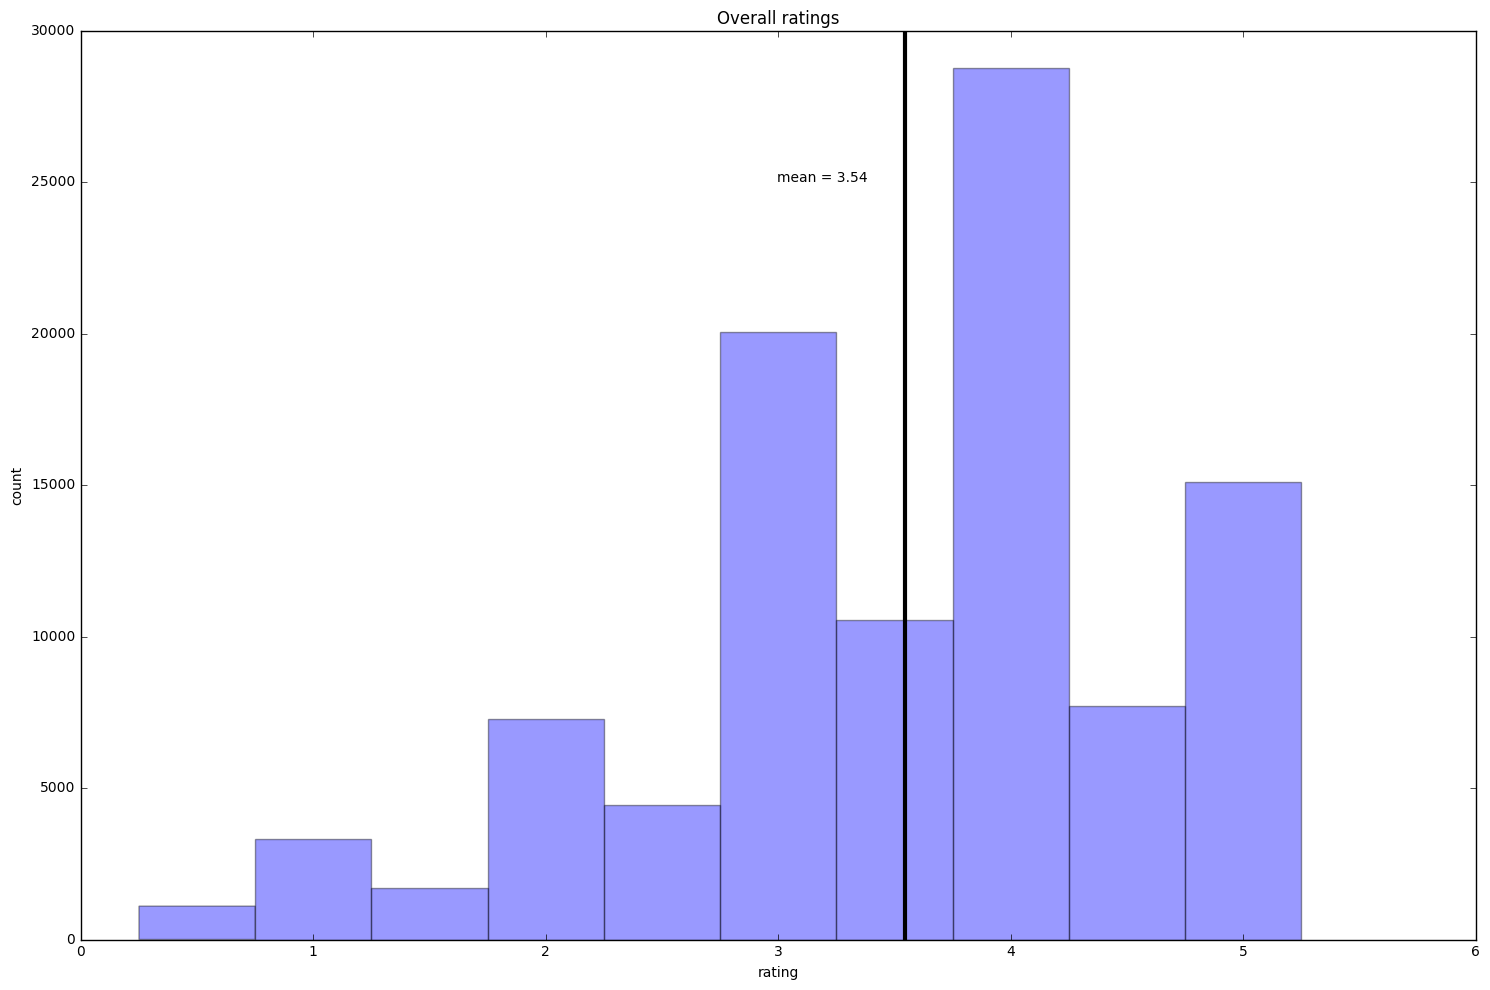

In [1]:
from collections import namedtuple, Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Dataset = namedtuple('Dataset', ['ratings_df', 'movies_df'])


def read_data():
    ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
    movies_df = pd.read_csv('ml-latest-small/movies.csv')
    return Dataset(ratings_df, movies_df)


def get_fig_size():
    return 15, 10


def show_ratings_histogram(ratings):
    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(ratings, bins=np.arange(0.25, 5.5, step=0.5), alpha=0.4)

    ratings_mean = ratings.mean()

    ax.axvline(x=ratings_mean, linewidth=3, color='k')
    plt.text(ratings_mean - 0.55, 25000, 'mean = %.2f' % ratings_mean)

    ax.set_xlabel('rating')
    ax.set_ylabel('count')
    ax.set_title('Overall ratings')

    plt.tight_layout()
    plt.show()


def explore_basic_stats(dataset):
    ratings_df = dataset.ratings_df
    movies_df = dataset.movies_df

    user_ids = ratings_df['userId']
    ratings = ratings_df['rating']

    print 'How many ratings? {:,}'.format(len(ratings_df))

    user_id_counter = Counter(user_ids)

    print 'How many users?', len(user_id_counter)
    print 'How many movies? {:,}'.format(len(movies_df))

    ratings_counter = Counter(ratings)

    print 'How many unique ratings?', len(ratings_counter.keys())
    print 'Unique rating values:', sorted(ratings_counter.keys())
    print 'Overall ratings mean: {:.2f}'.format(ratings.mean())

    show_ratings_histogram(ratings)

    
dataset = read_data()

explore_basic_stats(dataset)

# Number of ratings per user

The maximum number of ratings per user: 2391
The average number of ratings per user: 149.04
The minimum number of ratings per user: 20


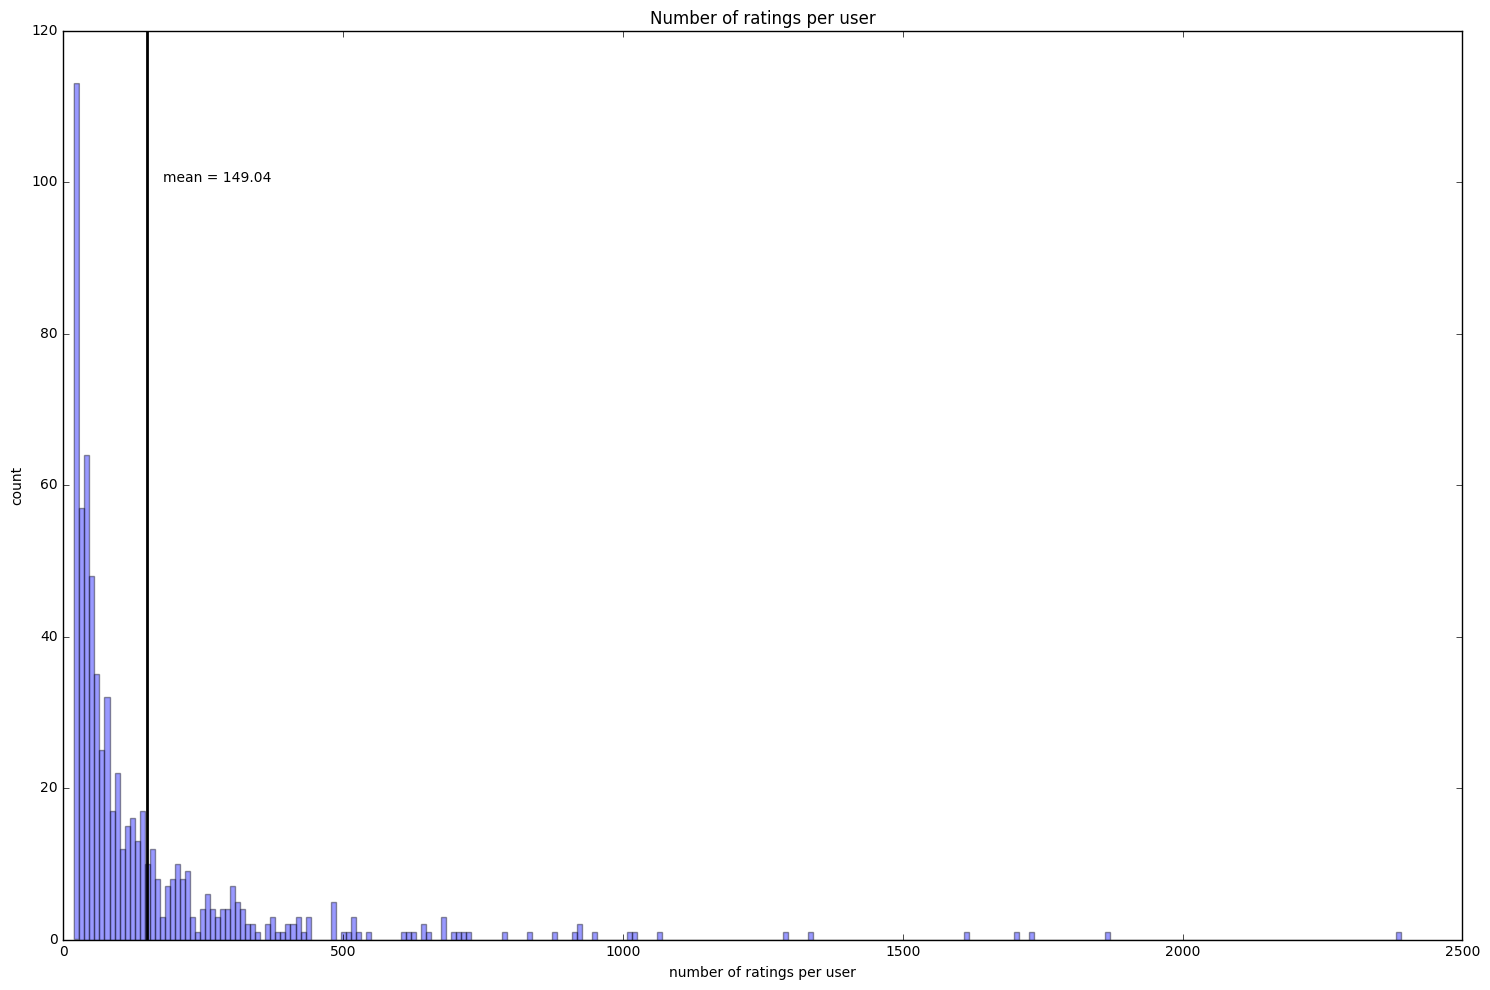

In [2]:
def explore_num_ratings_per_user(dataset):
    ratings_df = dataset.ratings_df
    user_ids = ratings_df['userId']

    user_id_counter = Counter(user_ids)
    num_ratings_per_user = user_id_counter.values()

    mean = np.mean(num_ratings_per_user)
    print 'The maximum number of ratings per user: %.0f' % np.max(num_ratings_per_user)
    print 'The average number of ratings per user: %.2f' % mean
    print 'The minimum number of ratings per user: %.0f' % np.min(num_ratings_per_user)

    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(num_ratings_per_user, bins=264, alpha=0.4)

    ax.axvline(x=mean, linewidth=2, color='k')
    plt.text(mean + 30, 100, 'mean = %.2f' % mean)

    ax.set_xlabel('number of ratings per user')
    ax.set_ylabel('count')
    ax.set_title('Number of ratings per user')

    plt.tight_layout()
    plt.show()

    
explore_num_ratings_per_user(dataset)

# User ratings

"User rating" here is the mean of all ratings for the given user.

The maximum user rating: 4.95
The mean user rating: 3.66
The minimum user rating: 1.33


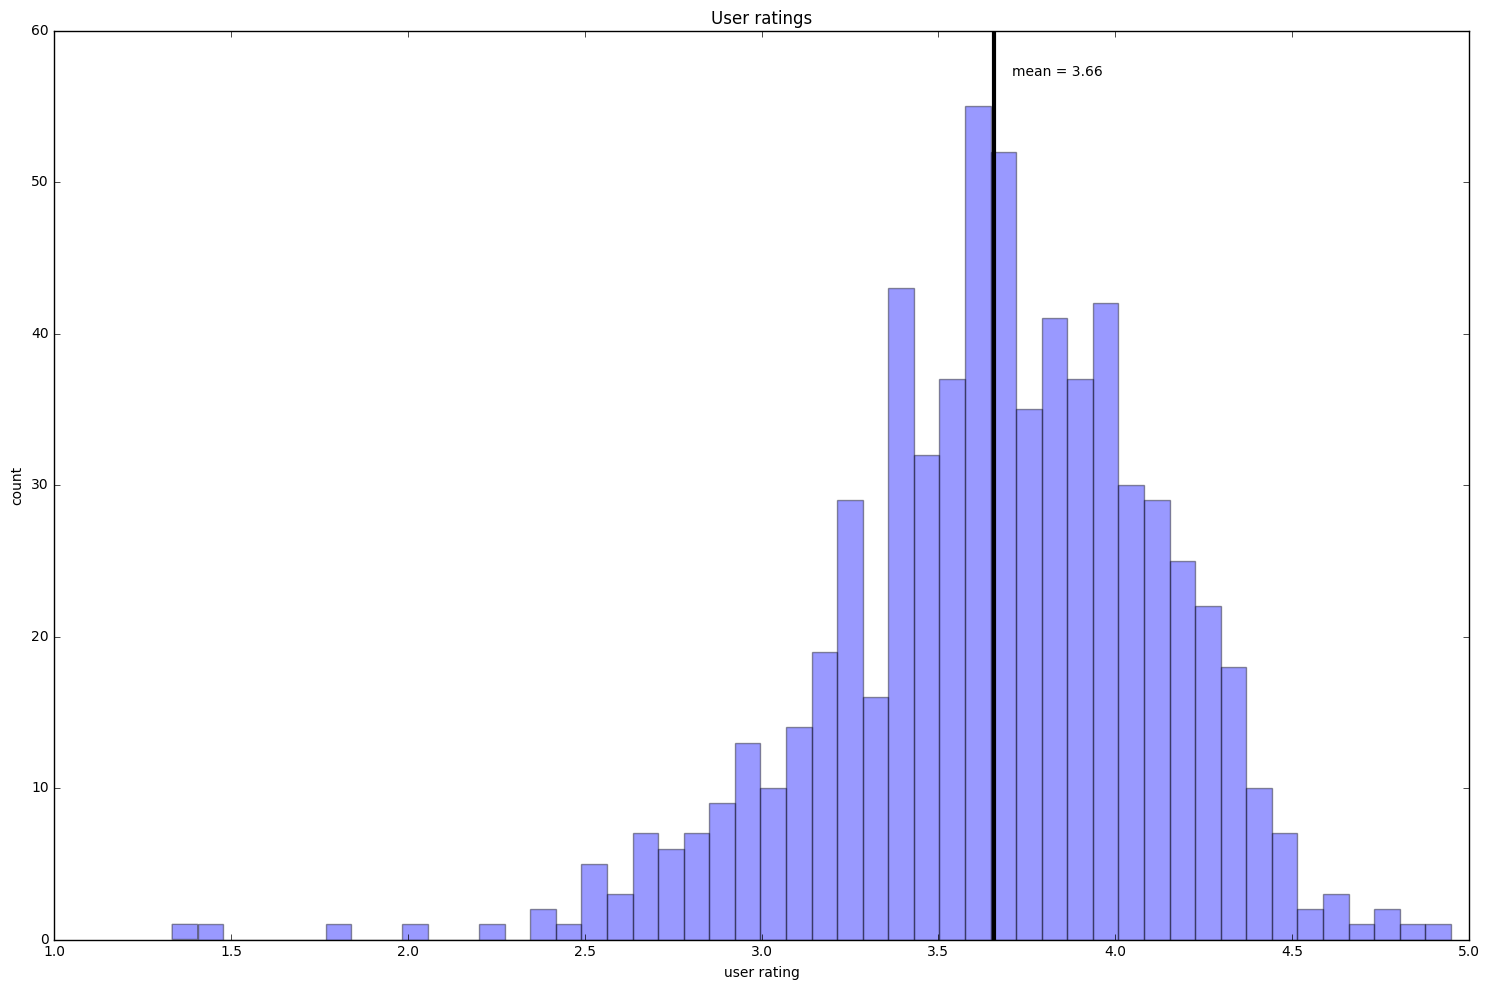

In [3]:
def explore_user_ratings(dataset):
    ratings_df = dataset.ratings_df

    user_ratings = ratings_df.groupby('userId')['rating'].mean()

    print 'The maximum user rating: %.2f' % user_ratings.max()
    user_ratings_mean = user_ratings.mean()
    print 'The mean user rating: %.2f' % user_ratings_mean
    print 'The minimum user rating: %.2f' % user_ratings.min()

    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(user_ratings, bins=50, alpha=0.4)

    ax.axvline(x=user_ratings_mean, linewidth=3, color='k')
    plt.text(user_ratings_mean + 0.05, 57, 'mean = %.2f' % user_ratings_mean)

    ax.set_xlabel('user rating')
    ax.set_ylabel('count')
    ax.set_title('User ratings')

    plt.tight_layout()
    plt.show()

    
explore_user_ratings(dataset)